# Practica: Redes convolucionales

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from MyUtils.plot import *

#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST

import torch.nn.functional as FUN

# MNIST con Pytorch
Pytorch facilita la creación de redes neuronales, como ejemplo puedes tomar la siguiente red que clasifica a los datos del conjunto MNIST haciendo uso de la arquitectura vista anteriormente: una capa de entrada con 784 neuronas, 27 neuronas en una capa oculta y una salida de 10 unidades.

Para implementar una red con esta herramienta debes extender a la clase nn.Module y a sus métodos:
- Constructor: donde estableces cuáles serán las capas que componen a la arquitectura
- Forward: donde indicas como se conectan las capas indicadas en el constructor

Ademas, para simplificar el proceso puedes agregar un metodo **train** al cual le pases el numero de iteraciones y otros parametros para entrenar la red.

In [23]:
#Descargamos el conjunto de datos en las variables.
train_dataset_mnist = MNIST(root='./data',train=True,download=True,
                          transform=transforms.ToTensor())
test_dataset_mnist  = MNIST(root='./data',train=False,download=True,
                          transform=transforms.ToTensor())

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

#Creamos un DataLoader,el cual nos permite iterar sobre nuestros datos y 
#administrarlos facilmente en lotes.
train_loader_mnist  = torch.utils.data.DataLoader(dataset=train_dataset_mnist,batch_size=64,
                                                 shuffle=True)

test_loader_mnist   = torch.utils.data.DataLoader(dataset=test_dataset_mnist,batch_size=64,
                                                 shuffle=True)

In [24]:
def reshape_mnist(batch):
    '''Recibe un batch de informacion de MNIST y lo aplana
    Ej: [5,28,28]-> [5,784]'''
    return batch.view(-1,28*28)

def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

In [ ]:
#Nuestro modelo debe heredar de nn.Module
class MNIST_NET(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(MNIST_NET,self).__init__()
        #Definimos nuestras unidades de entrada y las agregamos al objeto actual
        self.fc1 = nn.Linear(input_size,hidden_size,bias=True)
        self.sig1= nn.Sigmoid() 
        self.fc2 = nn.Linear(hidden_size,num_classes,bias=True)        
    
    def forward(self,input_data):
        '''Definimos como seran procesados los datos de entrada'''
        out=self.fc1(input_data) #Primero se hacen pasar por la capa lineal
        out=self.sig1(out)       #Despues,la salida para por la funcion sigmode
        out=self.fc2(out)        #La salida finalmente pasa por otra capa lineal
        return out

    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''Entrena la red net, por un numero de epocas "epochs" con el data_loader
        proporcionado,usando como funcion de perdida la definida en "criterion" y el
        optimizador pasado como parametro'''
        for epoch in range(epochs):
            for i,(images,labels) in enumerate(data_loader):

                images = Variable(images.view(-1,28*28))#aplanamos el batch actual
                labels = Variable(labels.view(-1,))     #convertimos el tensor a un tensor de valores unitarios
                if(cuda and torch.cuda.is_available()): #Si nuestra PC cuenta con GPU,realizamos calculos en ella
                    images=images.cuda()
                    labels=labels.cuda()

                optimizer.zero_grad()
                outputs= self(images)#llamar a nuestro objeto con parametros es introducirlos a la red
                loss   = criterion(outputs,labels)
                loss.backward()
                optimizer.step()

            if (epoch) % 2 == 0:                              # Logging
                print('Epoch [%d/%d], Step %d, Loss: %.4f'
                 %(epoch, epochs, i+1, loss.item()))
            
#Instanciamos la red que ya conocemos para MNIST de 28*28 --> 27 --> 10
Red =MNIST_NET(28*28,27,10)
#Red.cuda() #puedes descomentar esta linea si tienes GPU disponible
#Escogemos la funcion de error para el modelo (entropia cruzada)
criterio   = nn.CrossEntropyLoss()
optimizer  = torch.optim.SGD(Red.parameters(),lr=0.001)
#Entrenamos la red durante 100 pasos,con entropia cruzada y SGD 
Red.train(25,train_loader_mnist,criterio,optimizer,cuda=False) #puedes agregar cuda=true si tienes GPU disponible

Epoch [0/25], Step 938, Loss: 2.2337
Epoch [2/25], Step 938, Loss: 2.2609


In [ ]:
prec_train =calcularPrecisionGlobal(Red,train_loader_mnist,64,func=reshape_mnist,cuda=False)
prec_val   =calcularPrecisionGlobal(Red,test_loader_mnist,64,func=reshape_mnist,cuda=False)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

# Cifar 10 y redes convolucionales

La arquitectura que deberas implementar debe tener las siguientes caracteristicas:

    - Una capa convolucional de entrada con un filtro de 5x5x3 y 64 filtros de salida
    - Una capa de MaxPooling 
    - Otra capa convolucional con un filtro de 5x5x64 y 64 filtros de salida
    - Una capa de MaxPooling
    - Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
    - Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
    -Finalmente,una capa de salida con 10 neuronas
Es importante señalar que entre cada capa convolucional y de pooling existe una activacion **ReLu**

Graficamente, algo similar a lo mostrado en la siguiente figura:
<img src="AlexNet-cifar10.png" alt="Arquitectura de la red" title="Red convolucional" />

# Cifar 10
Es un conjunto de datos de imagenes que tiene 60,000 imagenes de 30x30 a color de 10 clases distintas (cada clase con 6,000 imagenes).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Para clasificar este conjunto de datos usaremos una red convolucional anteriormente descrita en Pytorch.

In [2]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


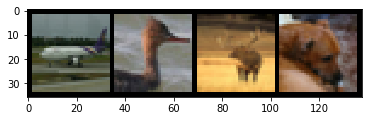

plane  bird  deer   dog


In [11]:
#Mostrando imagen
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''Constructor de la red neuronal
        En esta funcion defines las operaciones que seran realizadas y 
        las agregas a self para tenerlas disponibles despues'''
        super(CIFAR_NET, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,padding=0, dilation=1, groups=1, bias=True)
        #Una capa de neuronas  se declara con:
        #nn.Linear(in_features= x ,out_features=y)
        
        self.l1_conv = nn.Conv2d(3, 64, 5)
        self.l2_pool = nn.MaxPool2d(2)
        self.l3_conv = nn.Conv2d(64, 64, 5)
        self.l4_pool = nn.MaxPool2d(2)
        self.l5_linear = nn.Linear(64 * 5 * 5, 384)
        self.l6_linear = nn.Linear(384, 192)
        self.l7_linear = nn.Linear(192, 10)


    def forward(self, x):
        '''Ejecuta forward sobre los datos de entrada x
        En esta funcion debes definir de manera consecutiva el orden
        de las operaciones capa por capa que definiste en el constructor y
        devolver el resultado'''
        x = FUN.relu(self.l1_conv(x))
        x = self.l2_pool(x)
        x = FUN.relu(self.l3_conv(x))
        x = self.l4_pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = FUN.relu(self.l5_linear(x))
        x = FUN.relu(self.l6_linear(x))
        x = self.l7_linear(x)
        return x
    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''Entrena la red net, por un numero de epocas "epochs" con el data_loader
        proporcionado,usando como funcion de perdida la definida en "criterion" y el
        optimizador pasado como parametro'''
        #Recuerda incluir una manera de monitorizar el desempeño actual de la red
        #Es util mostrar el valor actual de perdida y de precision
        
        for epoch in range(2):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0

        print('Finished Training')

In [5]:
RedCIFAR=CIFAR_NET()
#RedCIFAR.cuda() #puedes descomentar esta linea si tienes GPU disponible
criterio = nn.CrossEntropyLoss()
optimizer = optim.SGD(RedCIFAR.parameters(), lr=0.001, momentum=0.9)

#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(50,trainloader,criterio,optimizer,cuda=False) #puedes agregar cuda=True si tienes GPU disponible

[1,  2000] loss: 2.209
[1,  4000] loss: 1.968
[1,  6000] loss: 1.778
[1,  8000] loss: 1.630
[1, 10000] loss: 1.545
[1, 12000] loss: 1.478
[2,  2000] loss: 1.409
[2,  4000] loss: 1.363
[2,  6000] loss: 1.298
[2,  8000] loss: 1.277
[2, 10000] loss: 1.224
[2, 12000] loss: 1.197
Finished Training


In [12]:
outputs = RedCIFAR.forward(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

#prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
#prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
#print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train),cuda=False)
#print("Precision en conjunto de validacion: %.4f%%"%(prec_val),cuda=False)

Predicted:  plane   cat  deer   cat


## Ejercicios:
    -- Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve.
    -- Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles y muestrala.
    
## Extra:
    -- Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.
    -- Graficar las imagenes del conjunto de datos bajo demanda.
    -- Muestra los filtros aprendidos.

NameError: name 'np' is not defined

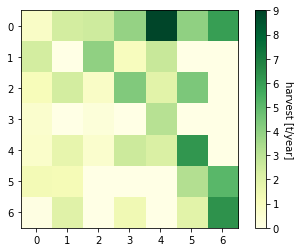

In [21]:
fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()